# Methodology (Deliverable 1 & 2):
**This notebook executes Pre-Processing using standarization and scaling techniques, each assessed using a Logistics Regression Classifier.**

* Split data into feature matrix (X) and target (y)
* Note the extent of imbalance among values in the target variable (y)
* Convert columns with dtype 'object' to numeric (using pd.get_dummies())
* Split data into a training and testing, setting aside 25 % of the data for testing (using train-test-split)

* Establish a baseline performance using using logistics regression classifier to compare the performance of all resampling techniques

* Feature scaling: standardize the features matrix (X) to better expose the underlying data patterns to the ML algorithms. The following techniques will be explored:
    - standardization using Standard Scaler
    
    - ~~standardiztion using RobustScaler  ~~
    
* Assess Performance: assess performance of each scaling technique in classsifying "high risk" or "low risk" using using logistics regression classifier (the baseline) using balanced accuracy score, confusion matrix and balanced classification report 
* Record findings in README.md file to include images of confusion matrix and balanced classification report

## Preprocessing - Scaling the feature matrix

### Import Libraries
Note a new python 3.7 evnironment called mlenv was created for this analysis

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

In [2]:
# sklearn dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# imbalanced-learn dependencies
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [4]:
# read in the csv file
df = pd.read_csv("./Data/clean_loans.csv")
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,20000.0,0.2250,769.00,RENT,75000.0,Not Verified,Mar-2019,low_risk,24.37,0.0,...,8.0,0.0,1.0,100.0,100.0,0.0,77797.0,55014.0,47000.0,30797.0
1,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,8.0,0.0,3.0,85.7,100.0,0.0,65687.0,38199.0,2000.0,61987.0
2,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,17.0,0.0,6.0,91.2,50.0,1.0,271427.0,60641.0,41200.0,49197.0
3,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,8.0,0.0,4.0,66.7,50.0,0.0,60644.0,45684.0,7500.0,43144.0
4,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,10.0,0.0,1.0,100.0,50.0,1.0,99506.0,68784.0,19700.0,76506.0


In [5]:
# examine the shape
df.shape

(90445, 74)

### Split data into feature matrix (X) and target (y)

In [6]:
# Create our features
X = df.drop(columns='loan_status')
X.shape

(90445, 73)

In [7]:
# Create our target
y = df['loan_status']
y.shape

(90445,)

### Note the extent of imbalance among values in the target variable (y)

In [8]:
# examine y for imbalance
y_value_counts = y.value_counts()

In [9]:
# There are very few instances of high risk loans to train any model on -- this is our imballanced problem
print(f"high_risk loans represent only {round(y_value_counts[1] / y_value_counts[0] * 100, 2)}% (about a half percent) of the loans in the dataset")

high_risk loans represent only 0.53% (about a half percent) of the loans in the dataset


### Pre-processing convert columns with dtype 'object' to numeric
##### Note: an explaination of how many columns will be added by get_dummies is added for better understanding of the get_dummies process (optional)

In [10]:
# what are our categorical value columns
columns_obj = df.select_dtypes(include='object').columns
print(len(columns_obj))

7


In [11]:
# get_dummies method in pandas
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'initial_list_status', 'next_pymnt_d', 'application_type'],
      dtype='object')

In [12]:
# examine a single column's value_counts (home_ownership)
df['home_ownership'].value_counts()

MORTGAGE    46204
RENT        33247
OWN         10248
ANY           745
NONE            1
Name: home_ownership, dtype: int64

In [13]:
# examine all the columns and each columns value_counts
for column in df[columns_obj]:
    print(column, "\n", df[column].value_counts())
    print("-----------------------------------")

home_ownership 
 MORTGAGE    46204
RENT        33247
OWN         10248
ANY           745
NONE            1
Name: home_ownership, dtype: int64
-----------------------------------
verification_status 
 Not Verified       43064
Source Verified    33344
Verified           14037
Name: verification_status, dtype: int64
-----------------------------------
issue_d 
 Jan-2019    40591
Feb-2019    33758
Mar-2019    16096
Name: issue_d, dtype: int64
-----------------------------------
loan_status 
 low_risk     89971
high_risk      474
Name: loan_status, dtype: int64
-----------------------------------
initial_list_status 
 w    79380
f    11065
Name: initial_list_status, dtype: int64
-----------------------------------
next_pymnt_d 
 May-2019    55743
Apr-2019    34702
Name: next_pymnt_d, dtype: int64
-----------------------------------
application_type 
 Individual    77925
Joint App     12520
Name: application_type, dtype: int64
-----------------------------------


In [14]:
# that is 18 values in seven columns therefore get_dummies
# will add 9 columns and remove 7 columns (18 columns added and the original 7 columns will be removed) for a change in shape by 11 columns
df.shape

(90445, 74)

### Use get_dummies

In [15]:
# use get_dummies to transform object dtypes into int 
X_encoded_dummies = pd.get_dummies(X)
X_encoded_dummies.shape

(90445, 84)

In [16]:
# check that all columns are now numeric
X_encoded_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90445 entries, 0 to 90444
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            90445 non-null  float64
 1   int_rate                             90445 non-null  float64
 2   installment                          90445 non-null  float64
 3   annual_inc                           90445 non-null  float64
 4   dti                                  90445 non-null  float64
 5   delinq_2yrs                          90445 non-null  float64
 6   inq_last_6mths                       90445 non-null  float64
 7   open_acc                             90445 non-null  float64
 8   pub_rec                              90445 non-null  float64
 9   revol_bal                            90445 non-null  float64
 10  total_acc                            90445 non-null  float64
 11  out_prncp                   

In [17]:
# all our columns in our features matrix (X) are numeric
# we can examine the differences in feature values using describe
X_encoded_dummies.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,90445.000000,90445.000000,90445.000000,9.044500e+04,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,...,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000
mean,16850.657858,0.126075,485.472852,8.626649e+04,20.684663,0.228946,0.446514,11.929736,0.118945,18221.420300,...,0.155199,0.373243,0.448792,0.177965,0.122340,0.877660,0.383681,0.616319,0.861573,0.138427
std,10370.740982,0.048078,291.337225,1.094292e+05,19.376007,0.742990,0.738874,5.947032,0.329078,22842.607779,...,0.362097,0.483669,0.497374,0.382485,0.327679,0.327679,0.486284,0.486284,0.345349,0.345349
min,1000.000000,0.060000,30.640000,4.000000e+01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9600.000000,0.081900,267.580000,5.000000e+04,12.630000,0.000000,0.000000,8.000000,0.000000,6438.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,407.350000,7.000000e+04,18.770000,0.000000,0.000000,11.000000,0.000000,12402.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.150200,652.130000,1.000000e+05,25.920000,0.000000,1.000000,15.000000,0.000000,22366.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308900,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,613796.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Confirm shape of y
y.shape

(90445,)

## save y as a csv file for use in ensemble modeling

In [19]:
# save y as a csv for use in ensemble modeling
y.to_csv("./Data/y.csv",index=False)

## save X_encoded_dummies as a csv file for use in ensemble modeling

In [20]:
# save X_encoded_dummies as a csv file using to_csv()

# df.to_csv(index=False)
X_encoded_dummies.to_csv("./Data/X_encoded_dummies.csv",index=False)

###################################### * * * * * * * * * * * * * * *  ####################################################

## Establish a Baseline for model performance using LogisticRegress

In [21]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_dummies, y, random_state = 1)

In [22]:
# examine the "balance" between high_risk and low_risk loans
value_counts = y_train.value_counts()
value_counts

low_risk     67488
high_risk      345
Name: loan_status, dtype: int64

In [23]:
# There are very few instances of high risk loans to train any model on -- this is our imballanced problem
print(f"high_risk loans represent only {round((value_counts[1] / value_counts[0]) * 100, 2)}% of the loans in the dataset")


high_risk loans represent only 0.51% of the loans in the dataset


In [24]:
# Instantiate a Logistic Regression Model
# modified solver to 'saga' and increased max_iter=10000 due to inability of 'lbfgs' solver to converge
LR_clf_baseline = LogisticRegression(solver='saga', random_state=1, max_iter=10000)
LR_clf_baseline

LogisticRegression(max_iter=10000, random_state=1, solver='saga')

In [25]:
# fit our model with our data (training)
LR_clf_baseline.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=1, solver='saga')

In [26]:
# create predictions using predict() method
y_pred_baseline = LR_clf_baseline.predict(X_test)
y_pred_baseline

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [27]:
# view the data
pd.DataFrame({"Prediction": y_pred_baseline, "Actual": y_test})

,Prediction,Actual
20763,low_risk,low_risk
53108,low_risk,low_risk
7350,low_risk,low_risk
61360,low_risk,low_risk
30820,low_risk,low_risk
...,...,...
64129,low_risk,low_risk
69371,low_risk,low_risk
26068,low_risk,low_risk
24929,low_risk,low_risk


In [28]:
# calculate model accuracy using balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred_baseline)

0.5

In [29]:
# create a confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print(cm)

[[    0   129]
 [    0 22483]]


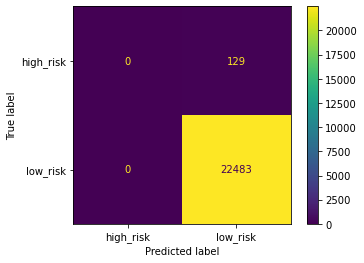

In [30]:
# confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= LR_clf_baseline.classes_)
disp.plot()

# save the image
plt.savefig("./Images/Baseline_confusion_matrix.png")
plt.show()

### Analysis: 
The Baseline Model (LogisticsRegression) performs well in identifying low_risk loans but fails at identifying any high_risk loans (common in Imbalanced Classification problems). 
### Explore scaling and resampling to improve model(s) performance

In [31]:
# view the imbalanced classification report
report = classification_report_imbalanced(y_test, y_pred_baseline)
print("Baseline / No changes in Sampling")
print(report)

C:\Users\jamie\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline / No changes in Sampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.00      0.00      1.00      0.00      0.00      0.00       129
   low_risk       0.99      1.00      0.00      1.00      0.00      0.00     22483

avg / total       0.99      0.99      0.01      0.99      0.00      0.00     22612



### StandarScaler: Transform the feature matrix using standard scaler 
Note: Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. Examples of such algorithm families include: linear and logistic regression.

In [32]:
# scale the X_encoded feature matrix
data_scaler = StandardScaler()

In [33]:
# fit and transform our X_encoded
X_encoded_std_scaled = data_scaler.fit_transform(X_encoded_dummies)

# examine the first row of the scaled feature matrix (note range of values are "close")
X_encoded_std_scaled[:1]

array([[ 0.30367739,  2.0576132 ,  0.97319769, -0.10295745,  0.1902021 ,
        -0.30814268, -0.60432087, -0.66079311, -0.36145199,  1.16942547,
        -1.03632788,  0.32183456,  0.32205506, -0.21091783, -0.21074539,
        -0.0878796 , -0.57442005, -0.03293001,  0.30593146, -0.11924753,
        -0.1026197 , -0.58936167, -0.81709012, -0.29901859, -0.76508319,
        -1.05440775,  1.1981363 , -0.59429551, -0.11866   , -0.6018011 ,
         1.9409899 ,  0.82725107,  0.12475722, -0.76364238, -0.57505135,
        -0.8183417 , -1.06953942, -0.43634701, -0.70919093,  1.60896999,
        -0.07930304, -0.00894059,  0.91620721,  0.21414825, -0.18223802,
         0.40450042, -0.80693722, -0.41822903, -0.32481931,  0.89183922,
         0.10874503,  0.28046495, -0.06405881, -0.63767168, -0.48538147,
        -0.78534611,  0.12237616, -0.65823761, -0.13871844, -0.5424113 ,
         0.59091002,  1.96241724, -0.3613543 , -0.64005886, -0.04115597,
         0.63596237, -0.38447069, -0.09113431, -1.0

### StandarScaler: Split the Data into Training and Testing

In [34]:
# from sklearn.model_selection import train_test_split
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_encoded_std_scaled, y, random_state = 1)

In [35]:
# examine the "balance" between high_risk and low_risk loans
value_counts = y_train_ss.value_counts()
value_counts

low_risk     67488
high_risk      345
Name: loan_status, dtype: int64

In [36]:
# There are very few instances of high risk loans to train any model on -- this is our imballanced problem
print(f"high_risk loans represent only {round((value_counts[1] / value_counts[0]) * 100, 2)}% of the loans in the dataset")


high_risk loans represent only 0.51% of the loans in the dataset


### StandardScaler: Assess with LogisticRegression
#### Model, fit, predict

#### get a baseline of performance usUse the LogisticRegression classifier to make predictions and evaluate the model’s performance.
* Calculate the accuracy score of the model.
* Generate a confusion matrix.
* Print out the imbalanced classification report for logistics regression


In [37]:
# Instantiate a Logistic Regression Model
# modified solver to 'saga' and increased max_iter=10000 due to inability of 'lbfgs' solver to converge
LR_clf_baseline = LogisticRegression(solver='saga', random_state=1, max_iter=10000)
LR_clf_baseline

LogisticRegression(max_iter=10000, random_state=1, solver='saga')

In [38]:
# fit our model with our data (training)
LR_clf_baseline.fit(X_train_ss, y_train_ss)

LogisticRegression(max_iter=10000, random_state=1, solver='saga')

In [39]:
# create predictions using predict() method
y_pred_baseline_std_scaler = LR_clf_baseline.predict(X_test)
y_pred_baseline_std_scaler

array(['high_risk', 'high_risk', 'high_risk', ..., 'high_risk',
       'high_risk', 'high_risk'], dtype=object)

In [40]:
# view the data
pd.DataFrame({"Prediction": y_pred_baseline_std_scaler, "Actual": y_test})

,Prediction,Actual
20763,high_risk,low_risk
53108,high_risk,low_risk
7350,high_risk,low_risk
61360,high_risk,low_risk
30820,high_risk,low_risk
...,...,...
64129,high_risk,low_risk
69371,high_risk,low_risk
26068,high_risk,low_risk
24929,high_risk,low_risk


In [41]:
# calculate model accuracy
balanced_accuracy_score(y_test_ss, y_pred_baseline_std_scaler)

0.5

In [42]:
# create a confusion matrix
cm_ss = confusion_matrix(y_test_ss, y_pred_baseline_std_scaler)
print(cm)

[[    0   129]
 [    0 22483]]


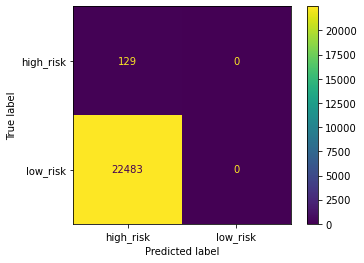

In [43]:
# confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ss,display_labels= LR_clf_baseline.classes_)
disp.plot()

# save the image
plt.savefig("./Images/Baseline_Std_Scaler_confusion_matrix.png")
plt.show()

### Analysis:
Use of StandardScaler increased the models's ability to identify (a few additional) high_risk loan as as high_risk

In [44]:
# view the imballanced classification report
# report = classification_report(y_test, y_pred, output_dict=True)
baseline_report = classification_report_imbalanced(y_test_ss, y_pred_baseline_std_scaler, output_dict=True)
print("Baseline / standard scaled No changes in Sampling")
print(report)

C:\Users\jamie\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline / standard scaled No changes in Sampling
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.00      0.00      1.00      0.00      0.00      0.00       129
   low_risk       0.99      1.00      0.00      1.00      0.00      0.00     22483

avg / total       0.99      0.99      0.01      0.99      0.00      0.00     22612



## Oversampling (after scaling with StandardScaler)

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### RandomOverSampler

In [45]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_ss, y_train_ss)

In [46]:
# what is the "balance" or mix between loan_staus
Counter(y_resampled_ros)

Counter({'low_risk': 67488, 'high_risk': 67488})

#### Assess using LogisticRegression

In [47]:
# Train the Logistic Regression model using the resampled data
# from sklearn.linear_model import LogisticRegression

# model
LR_clf_ros = LogisticRegression(solver='saga', random_state=1, max_iter=10000)

# fit
LR_clf_ros.fit(X_resampled_ros, y_resampled_ros)

# predict using the predict method
y_pred_ros = LR_clf_ros.predict(X_test_ss)

##### Balanced accuracy score

In [48]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test_ss, y_pred_ros)

0.8183731929068199

##### Confusion Matrix

In [49]:
# Display the confusion matrix
cm_ros = confusion_matrix(y_test_ss, y_pred_ros, labels=LR_clf_ros.classes_)
print(cm)

[[    0   129]
 [    0 22483]]


##### ConfusionMatrixDisplay

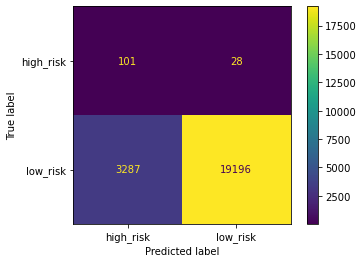

In [50]:
# confusion matrix using ConfusionMatrixDisplay
disp_ros = ConfusionMatrixDisplay(confusion_matrix=cm_ros, display_labels= LR_clf_ros.classes_)
disp_ros.plot()

# save the image
plt.savefig("./Images/RandomOverSampler_confusion_matrix.png")
plt.show()

##### Imbalanced Classification Report

In [51]:
# Print the imbalanced classification report
# high_risk       0.81      0.21      1.00
print("RandomOverSampler")
print(classification_report_imbalanced(y_test_ss, y_pred_ros))

RandomOverSampler
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.78      0.85      0.06      0.82      0.66       129
   low_risk       1.00      0.85      0.78      0.92      0.82      0.67     22483

avg / total       0.99      0.85      0.78      0.92      0.82      0.67     22612



### SMOTE Oversampling

In [52]:
# Resample the training data with SMOTE
# Train the Logistic Regression model using the resampled data
X_resampled_SMOTE, y_resampled_SMOTE = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(X_train_ss, y_train_ss)

In [53]:
# check the balance of loan_status
Counter(y_resampled_SMOTE)


Counter({'low_risk': 67488, 'high_risk': 67488})

#### Assess using LogisticRegression

In [54]:
# model
LR_clf_SMOTE = LogisticRegression(solver='saga', random_state=1, max_iter=10000)

# train/fit
LR_clf_SMOTE.fit(X_resampled_SMOTE, y_resampled_SMOTE)

# predict
y_pred_SMOTE = LR_clf_SMOTE.predict(X_test_ss)

##### Balanced accuracy score

In [55]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test_ss, y_pred_SMOTE)

0.8078889579620364

##### Confusion Matrix

In [56]:
# Display the confusion matrix
cm = confusion_matrix(y_test_ss, y_pred_SMOTE,  labels=LR_clf_SMOTE.classes_)
print(cm)

[[   96    33]
 [ 2887 19596]]


##### ConfusionMatrixDisplay

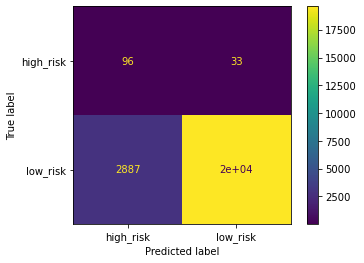

In [57]:
# confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= LR_clf_SMOTE.classes_)
disp.plot()

# save the image
plt.savefig("./Images/SMOTE_confusion_matrix.png")
plt.show()

##### Imbalanced Classification Report

In [58]:
# Print the imbalanced classification report
print("SMOTE")
print(classification_report_imbalanced(y_test_ss, y_pred_SMOTE))

SMOTE
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.74      0.87      0.06      0.81      0.64       129
   low_risk       1.00      0.87      0.74      0.93      0.81      0.66     22483

avg / total       0.99      0.87      0.74      0.93      0.81      0.66     22612



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### ClusterCentroids resampler

In [59]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled_cc, y_resampled_cc = cc.fit_resample(X_train_ss, y_train_ss)

#### Assesss using Logisticregression

In [60]:
# Train the Logistic Regression model using the resampled data
LR_clf_cc = LogisticRegression(solver='saga', random_state=1, max_iter=10000)
LR_clf_cc.fit(X_resampled_cc, y_resampled_cc)

LogisticRegression(max_iter=10000, random_state=1, solver='saga')

In [61]:
# predict
y_pred_cc = LR_clf_cc.predict(X_test_ss)

##### Balanced accuracy score

In [62]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test_ss, y_pred_cc)

0.7868287736436177

##### Confusion Matrix

In [63]:
# Display the confusion matrix
cm_cc = confusion_matrix(y_test_ss, y_pred_cc, labels=LR_clf_cc.classes_)
print(cm)

[[   96    33]
 [ 2887 19596]]


##### ConfusionMatrixDisplay

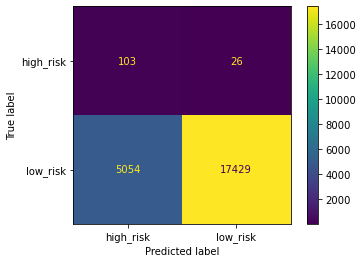

In [64]:
# diplay the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cc,display_labels= LR_clf_cc.classes_)
disp.plot()

# save the image
plt.savefig("./Images/ClusterCentroids_confusion_matrix.png")
plt.show()

##### Imbalanced Classification Report

In [65]:
# Print the imbalanced classification report
print("ClusterCentroids")
print(classification_report_imbalanced(y_test_ss, y_pred_cc))

ClusterCentroids
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.80      0.78      0.04      0.79      0.62       129
   low_risk       1.00      0.78      0.80      0.87      0.79      0.62     22483

avg / total       0.99      0.78      0.80      0.87      0.79      0.62     22612



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### SMOTEENN resampler

In [66]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete

# model
smote_enn = SMOTEENN(random_state=1, sampling_strategy='auto')

# fit the data to the smoteen model
X_resampled_SMOTEENN, y_resampled_SMOTEENN = smote_enn.fit_resample(X_train_ss, y_train_ss)
Counter(y_resampled_SMOTEENN)


Counter({'high_risk': 67488, 'low_risk': 63328})

#### Assesss using Logisticregression

In [67]:
# Train the Logistic Regression model using the resampled (smoteenn) data
# model
LR_clf_SMOTEENN = LogisticRegression(solver='saga', random_state=1, max_iter=10000)

# fit
LR_clf_SMOTEENN.fit(X_resampled_SMOTEENN, y_resampled_SMOTEENN)

# predict
y_pred_SMOTEENN = LR_clf_SMOTEENN.predict(X_test_ss)

##### Balacned accuracy score

In [68]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test_ss, y_pred_SMOTEENN)

0.8190339850229649

##### Confusion Matrix

In [69]:
# Display the confusion matrix
cm_SMOTEENN = confusion_matrix(y_test_ss, y_pred_SMOTEENN)

##### ConfusionMatrixDisplay

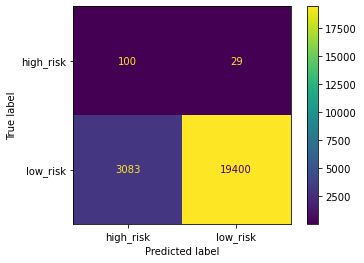

In [70]:
# diplay the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SMOTEENN,display_labels= LR_clf_SMOTEENN.classes_)
disp.plot()

# save the image
plt.savefig("./Images/SMOTEENN_confusion_matrix.png")
plt.show()

##### Imbalanced Classification Report

In [71]:
# Print the imbalanced classification report
print("SMOTEENN")
print(classification_report_imbalanced(y_test_ss, y_pred_SMOTEENN))

SMOTEENN
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.78      0.86      0.06      0.82      0.66       129
   low_risk       1.00      0.86      0.78      0.93      0.82      0.67     22483

avg / total       0.99      0.86      0.78      0.92      0.82      0.67     22612



## Resampling Analysis